## CFD Códigos Implementados
### Jean Pierre Rojas - Byron Vega 

In [1]:
# Llamado de librerías 
import numpy 
from math import pi 
from scipy import linalg
from scipy.linalg import solve
from scipy import sparse 
from scipy.sparse.linalg import spsolve 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [18]:
# Función predicción 2.4v
def prediccion(u,v,dx,dy,dt,nu,u0,N):
    ua = numpy.zeros((N,N))
    va = numpy.zeros((N,N))
    ua[1:-1,1:-1]=u[1:-1,1:-1]- u[1:-1,1:-1]*dt/dx*(u[1:-1,1:-1]-u[1:-1,0:-2])-v[1:-1,1:-1]*dt/dy*(u[1:-1,1:-1]-u[0:-2,1:-1]) + nu*dt/dx**2*(u[1:-1,2:]-2*u[1:-1,1:-1]+u[1:-1,0:-2])+nu*dt/dy**2*(u[2:,1:-1]-2*u[1:-1,1:-1]+u[0:-2,1:-1])
    va[1:-1,1:-1]=v[1:-1,1:-1]- u[1:-1,1:-1]*dt/dx*(v[1:-1,1:-1]-v[1:-1,0:-2])-v[1:-1,1:-1]*dt/dy*(v[1:-1,1:-1]-v[0:-2,1:-1]) + nu*dt/dx**2*(v[1:-1,2:]-2*v[1:-1,1:-1]+v[1:-1,0:-2])+nu*dt/dy**2*(v[2:,1:-1]-2*v[1:-1,1:-1]+v[0:-2,1:-1])
            
    #CB de dirichlet en todos lados
    ua[0,:]=0
    ua[:,0]=0
    ua[:,-1]=0
    ua[-1,:]=u0
        
    va[0,:]=0
    va[-1,:]=0
    va[:,0]=0
    va[:,-1]=0
    
    return ua,va

In [102]:
#Se define la divergencia 2.3v
def divergenciaV(ua,va,dx,dy,u0,N):
    div = numpy.zeros((N,N))
    #los vertices del cuadrado
    #div[0,0]=(rho*dt)*((ua[1,0]-ua[0,0])/(2*dx) + (va[0,1]-va[0,0])/(2*dy))
    #div[0,-1]=(rho*dt)*((ua[1,-1]-ua[0,-1])/(2*dx) + (va[0,-1]-va[0,-2])/(2*dy))
    #div[-1,0]=(rho*dt)*((ua[-1,0]-ua[-2,0])/(2*dx) + (va[-1,1]-va[-1,0])/(2*dy))
    #div[-1,-1]=(rho*dt)*((ua[-1,-1]-ua[-2,-1])/(2*dx) + (va[-1,-1]-va[-1,-2])/(2*dy))
    #Resto de los bordes
    #div[0,1:-1] = ((ua[0,2:]-ua[0,:-2])/(2*dx) + (va[1,2:]-va[0,1:-1])/(2*dy)) #izquierda
    #div[-1,1:-1] = ((ua[-1,2:]-ua[-1,2:])/(2*dx) + (va[-1,1:-1]-va[-1,2:])/(2*dy)) #derecha
    #div[1:-1,0] = ((ua[2:,0]-ua[:-2,0])/(2*dx) + (va[1:-1,1]-va[1:-1,0])/(2*dy)) #abajo jj
    #div[1:-1,-1] = ((ua[2:,-1]-ua[:-2,-1])/(2*dx) + (va[1:-1,-1]-va[1:-1,-2])/(2*dy)) #arriba
    #puntos interiores
    div[1:-1,1:-1]= ((ua[1:-1,2:]-ua[1:-1,:-2])/(2*dx) + (va[2:,1:-1]-va[:-2,1:-1])/(2*dy))
    return div

In [90]:
def divergenciaV2(ua,va,dx,dy,u0,N):
    #no autoría propia
    grad = numpy.zeros((N-2)*(N-2))
    cont = 0
    for j in range(1,N-1):
        for i in range(1,N-1):
            grad[cont] = -delta*rho/(2*dt)*(ua[j,i+1]-u[j,i-1]+v[j+1,1]-v[j-1,i])
            cont += 1
    return grad

In [91]:
def divergenciaV3(ua,va,dx,dy,u0,N):
    #no autoría propia 
    grad = numpy.zeros((N,N))
    for j in range(N-1):
        for i in range(N-1):
            grad[j,i] = (rho*dt)*((ua[j,i+1]-ua[j,i-1])/(2*dx) + (va[j+1,1]-va[j-1,i])/(2*dy))
    return grad

In [92]:
# Función MAP 1.0v
def map_1Dto2D(N, phi_1D):

    phi = numpy.zeros((N,N))
    
    row_number = 0
    for j in range(1,N-1):
        for i in range(1,N-1):
            phi[j,i] = phi_1D[row_number]
            row_number += 1
    # Dirichlet BC
    phi[0,:] = phi[1,:]
    phi[:,0] = phi[:,1]
    phi[N-1,:] = phi[N-2,:]
    phi[:,N-1] = phi[:,N-2]  #Derecha 

    return phi  

#Generación matriz N 
def generateMatrix(N):
    #Autor: Profesores Cooper&Scurtys
    A = numpy.zeros(((N-2)*(N-2),(N-2)*(N-2)))
    
    row_number = 0 # row counter
    for j in range(1,N-1):
        for i in range(1,N-1):
            
            # Corners
            if i==1 and j==1: # Bottom left corner (Dirichlet down and left)
                A[row_number,row_number] = 4        # Set diagonal
                A[row_number,row_number+1] = -1     # fetch i+1
                A[row_number,row_number+N-2] = -1   # fetch j+1
                
            elif i==N-2 and j==1: # Bottom right corner (Dirichlet down, Neumann right)
                A[row_number,row_number] = 3         # Set diagonal
                A[row_number,row_number-1] = -1      # Fetch i-1
                A[row_number,row_number+N-2] = -1    # fetch j+1
                
            elif i==1 and j==N-2: # Top left corner (Neumann up, Dirichlet left)
                A[row_number,row_number] = 3          # Set diagonal
                A[row_number,row_number+1] = -1       # fetch i+1
                A[row_number,row_number-(N-2)] = -1   # fetch j-1
                
            elif i==N-2 and j==N-2: # Top right corner (Neumann up and right)
                A[row_number,row_number] = 2          # Set diagonal
                A[row_number,row_number-1] = -1       # Fetch i-1
                A[row_number,row_number-(N-2)] = -1   # fetch j-1
              
            # Sides
            elif i==1: # Left boundary (Dirichlet)
                A[row_number,row_number] = 4         # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number+N-2] = -1    # fetch j+1
                A[row_number,row_number-(N-2)] = -1  # fetch j-1
            
            elif i==N-2: # Right boundary (Neumann)
                A[row_number,row_number] = 3        # Set diagonal
                A[row_number,row_number-1] = -1     # Fetch i-1
                A[row_number,row_number+N-2] = -1   # fetch j+1
                A[row_number,row_number-(N-2)] = -1 # fetch j-1
                
            elif j==1: # Bottom boundary (Dirichlet)
                A[row_number,row_number] = 4        # Set diagonal
                A[row_number,row_number+1] = -1     # fetch i+1
                A[row_number,row_number-1] = -1     # fetch i-1
                A[row_number,row_number+N-2] = -1   # fetch j+1
                
            elif j==N-2: # Top boundary (Neumann)
                A[row_number,row_number] = 3         # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number-(N-2)] = -1  # fetch j-1
                
            # Interior points
            else:
                A[row_number,row_number] = 4         # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number+N-2] = -1    # fetch j+1
                A[row_number,row_number-(N-2)] = -1  # fetch j-1
                
            row_number += 1 # Jump to next row of the matrix!
            
    return A

In [93]:
def generateRHS(N, F, X, Y, u0, delta):
    
    RHS = numpy.zeros((N-2)*(N-2))
    
    row_number = 0 # row counter
    for j in range(1,N-1):
        for i in range(1,N-1):
            # En este problema particular podemos simplificar dado que todas las condiciones de 
            # DC son cero y son de dirichlet. 
            RHS[row_number] = -F[j,i]*delta**2    
            row_number += 1
        
    return RHS

In [94]:
def gradienteP(P,dx,dy,N): 
    gradx = numpy.zeros((N,N))
    grady = numpy.zeros((N,N))
    gradx[1:-1,1:-1] = (P[1:-1,2:]-P[1:-1,:-2])/(2*dx)
    grady[1:-1,1:-1] = (P[2:,1:-1]-P[:-2,1:-1])/(2*dy)
    #gradx[0,:] = 0 #gradx[1,:]
    #gradx[-1,:] = 0 #gradx[-2,:]
    #grady[:,0] = 0 #gradx[:,1]
    #grady[:,-1] = 0 #gradx[:,-2]
    return gradx, grady

def correccion(u,v,dt,rho,gradx,grady,N):
    uc = numpy.zeros((N,N))
    vc = numpy.zeros((N,N))
    uc[1:-1,1:-1] = u[1:-1,1:-1]-(dt/rho)*gradx[1:-1,1:-1]
    vc[1:-1,1:-1] = v[1:-1,1:-1]-(dt/rho)*grady[1:-1,1:-1]

    return uc,vc 
    

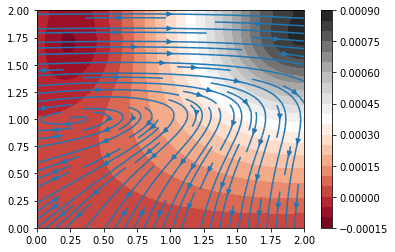

In [113]:
xmin = 0.
xmax = 2.
ymin = 0.
ymax = 2.

N = 41

delta = (xmax-xmin)/(N-1)
dx = delta
dy = delta 

x = numpy.linspace(xmin, xmax, N)
y = numpy.linspace(ymin, ymax, N)
X,Y = numpy.meshgrid(x,y)

dt = 0.001 
u0 = 1. 
nu = 0.5  #0.1 
rho = 1 

u=numpy.zeros((N,N))
v=numpy.zeros((N,N))
u[N-1,:] = u0

pt = 100

t=0 

M = generateMatrix(N)
Msparse = sparse.csr_matrix(M)

while t <= (dt*pt): 
    ua,va = prediccion(u,v,dx,dy,dt,nu,u0,N)
    div = divergenciaV(ua,va,dx,dy,u0,N)
    #div = div[1:-1,1:-1]
    RHS = generateRHS(N, div, X, Y, u0, delta) 
    #print(RHS)
    sol = solve(M,RHS)
    #sol = solve(Msparse,div)
    
    P = map_1Dto2D(N, sol)
    
    gradx,grady = gradienteP(P,dx,dy,N)
    
    u,v =correccion(ua,va,dt,nu,gradx,grady,N)
    
    t += dt
  
%matplotlib inline
fig1 = plt.streamplot(X,Y,u,v,density=1) 
plt.contourf(X,Y,P,20,cmap='RdGy')
plt.colorbar()

#### Sección de Ensayos 

In [83]:
a = numpy.zeros((5,5))
a[0,:] = [2., 3., 1., 4., 6.]
a[1,:] = [5., 2., 3., 6., 7.]
a[2,:] = [1., 6., 4., 3., 5.]
a[3,:] = [3., 5., 8., 7., 3.]
a[4,:] = [4., 8., 2., 5., 9.]

b = numpy.zeros((5,5))
b[0,:] = [3, 4, 1, 5, 7]
b[1,:] = [6, 3, 4, 7, 8]
b[2,:] = [2, 7, 3, 4, 6]
b[3,:] = [1, 5, 9, 6, 2]
b[4,:] = [5, 2, 8, 9, 1]

c = numpy.zeros((5,5))
d = numpy.zeros((5,5))
#print(a[1:-1,1:-1])
#c[1:-1,1:-1] = (a[1:-1,2:]-a[1:-1,:-2])/(2*dx) + (b[2:,1:-1]-b[:-2,1:-1])/(2*dy)
#print(c)

c = a[1:-1,1:-1]
#print(len(b)-1)
#d = divergenciaV(a,b,dx,dy,u0,5)
#c = divergenciaV3(a,b,dx,dy,u0,5)
#ua,va = prediccion(a,b,dx,dy,dt,nu,u0,5)
#div = divergenciaV(ua,va,dx,dy,u0,5)

print(c)




[[2. 3. 6.]
 [6. 4. 3.]
 [5. 8. 7.]]
